In [52]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import distinct

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# ==== To check what table is available ===
# from sqlalchemy import inspect


In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)



In [8]:
# ================== My Notes===============
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

engine.execute('SELECT * FROM station LIMIT 5').fetchall()



# ***session = Session(engine)
# **** engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()


[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
# ****Saving reference to classes
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# inspector = inspect(engine)
# inspector.get_table_names()

In [36]:
# from sqlalchemy import MetaData
# metadata=MetaData()
# metadata.reflect(engine, only=['measurement'])

# Get column names
from sqlalchemy import inspect
inspector = inspect(engine)

# column name for measurement
columns = inspector.get_columns('measurement') # add table name here
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [37]:
# column name for measurement
columns = inspector.get_columns('station') # add table name here
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

2017-08-23
2016-08-23


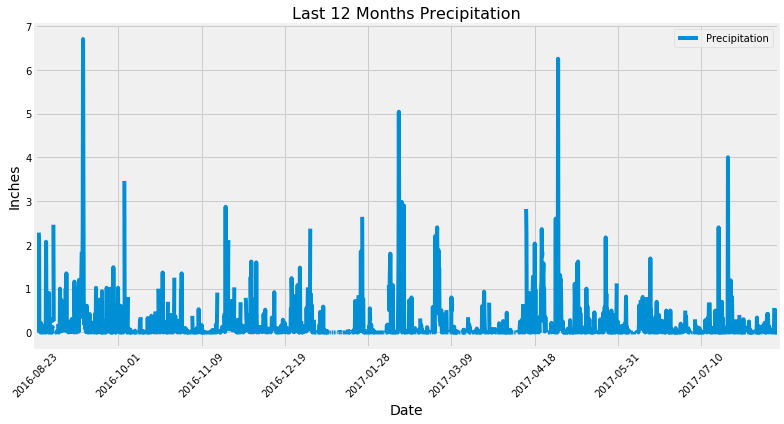

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


Max_Date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
Max_Date # ('2017-08-23')

# Retrieve max date
End_Date = Max_Date[0]
print(End_Date)

# Calculate the date 1 year ago from the last data point in the database
Twelve_Months = dt.datetime.strptime(End_Date, '%Y-%m-%d')  - dt.timedelta(days=365) # Go back 365 days on Max_Date 2017-08-23
Begin_Date  = Twelve_Months.strftime('%Y-%m-%d')
print(Begin_Date)

# Perform a query to retrieve the data and precipitation scores
#-- Query to retrieve precipitaion data between 2016-08-23 and 2017-08-23 
rollback12_precip = session.query(Measurement.prcp, Measurement.date).filter(Measurement.date >= Begin_Date)\
                                    .filter(Measurement.date <= End_Date)\
                                    .order_by(Measurement.date.desc()).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(rollback12_precip)
precip_df.rename(columns={'prcp': 'Precipitation', 'date': 'Date'}, inplace=True) # Rename column

# set Date as index
precip_df.set_index('Date', inplace=True)

# Sort the dataframe by date
precip_df.sort_values(by=['Date'], inplace=True, ascending=True)
precip_df.head()


# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(rot=45, figsize=(11,6))
plt.title('Last 12 Months Precipitation', size=16) # Format title 
plt.xlabel(xlabel='Date', size=14) # Format x label
plt.ylabel(ylabel='Inches', size=14) # Format y label
plt.tight_layout()
plt.savefig("../sqlalchemy-challenge/Last 12 Months Precipitaion.png") 
plt.show()





In [27]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [58]:
# Design a query to show how many stations are available in this dataset?
#from sqlalchemy import distinct
 
# count distinct "station" values
nbr_of_station =session.query(func.count(distinct(Measurement.station))).all()

nbr_of_station
print(f'The number of station available: {nbr_of_station[0][0]}')

The number of station available: 9


In [76]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
nbr_of_station_nbr=session.query(Measurement.station,func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()


nbr_of_station_nbr



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [127]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Query min temp
min_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()

# Query max temp
max_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()

# Query average temp
avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").all()

# print results
print(f'Station USC00519281 Lowest Temperature: {min_temp[0][0]}') 
print(f'Station USC00519281 Highest Temperature: {max_temp[0][0]}')
print(f'Station USC00519281 Average Temperature: {round(avg_temp[0][0],2)}')

Station USC00519281 Lowest Temperature: 54.0
Station USC00519281 Highest Temperature: 85.0
Station USC00519281 Average Temperature: 71.66


In [262]:
# Choose the station with the highest number of temperature observations.

# Retrieve highest number of temp obersvations
highest_observation_station=session.query(Measurement.station,func.count(Measurement.tobs)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.tobs).desc()).first()


high_obs_station = highest_observation_station[0]
high_obs_station


'USC00519281'

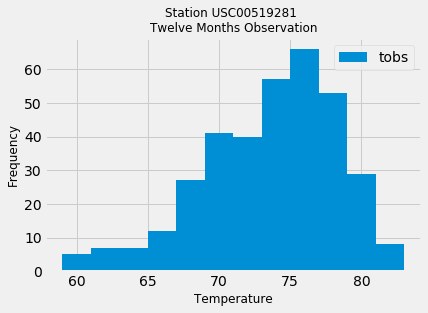

In [261]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Last 12 months and temperature on the highest number of temp obseration station 'USC00519281'
highest_obser_station =session.query(Measurement.tobs, Measurement.date)\
                    .filter(Measurement.date >= Begin_Date)\
                    .filter(Measurement.station == high_obs_station)\
                    .order_by(Measurement.date.asc()).all()


highest_obser_station
                 
# Add results to a dataframe    
high_station_df = pd.DataFrame(highest_obser_station)
high_station_df
   
# Plot histogram    
salary_hist=high_station_df['tobs'].hist(bins=12) #,figsize=(11,6)
salary_hist.set_xlabel('Temperature',size='12')  # format x label
salary_hist.set_ylabel('Frequency',size='12') # format y label
salary_hist.set_title('Station ' + high_obs_station + ' \nTwelve Months Observation', size='12') #set title
plt.legend(['tobs'],loc='upper right') # Format legend

# Save chart png 
plt.savefig("../sqlalchemy-challenge/Last 12 Months USC00519281.png") 
plt.show()


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
